<a href="https://colab.research.google.com/github/MohdDilshad-nitk/pytorch/blob/main/Transformer_with_validation_and_csv_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip '/content/processed_skeleton_data.zip'

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import random
import re

class SkeletonDataAugmenter:
    def __init__(self, processed_data_dir):
        """
        Initialize the skeleton data augmenter

        Args:
            processed_data_dir (str): Directory containing the processed CSV files
        """
        self.processed_data_dir = Path(processed_data_dir)
        self.metadata = pd.read_csv(self.processed_data_dir / 'metadata.csv')

    def normalize_to_range(self, sequence):
        """
        Normalize sequence to [0,1] range
        """
        min_vals = sequence.min()
        max_vals = sequence.max()
        normalized = (sequence - min_vals) / (max_vals - min_vals + 1e-7)
        return normalized

    def random_crop_sequence(self, sequence, min_frames=30):
        """Random continuous crop of sequence"""
        num_frames = len(sequence)
        if num_frames <= min_frames:
            return sequence

        crop_length = random.randint(min_frames, num_frames)
        start_idx = random.randint(0, num_frames - crop_length)
        return sequence.iloc[start_idx:start_idx + crop_length]

    def random_drop_frames(self, sequence, drop_ratio_range=(0.1, 0.3)):
        """Randomly drop and interpolate frames"""
        num_frames = len(sequence)
        drop_ratio = random.uniform(*drop_ratio_range)
        num_drops = int(num_frames * drop_ratio)

        if num_drops == 0:
            return sequence

        drop_indices = sorted(random.sample(range(num_frames), num_drops))
        sequence_dropped = sequence.drop(sequence.index[drop_indices])
        return sequence_dropped.interpolate(method='linear')

    def add_gaussian_noise(self, sequence, noise_level_range=(0.01, 0.03)):
        """Add random Gaussian noise to joint positions and normalize"""
        noise_level = random.uniform(*noise_level_range)
        noise = np.random.normal(0, noise_level, sequence.shape)
        noisy_sequence = pd.DataFrame(
            sequence.values + noise,
            columns=sequence.columns
        )
        return self.normalize_to_range(noisy_sequence)

    def scale_sequence(self, sequence, scale_range=(0.8, 1.2)):
        """Scale the joint positions"""
        scale = random.uniform(*scale_range)
        scaled = sequence * scale
        return self.normalize_to_range(scaled)

    def time_scale(self, sequence, scale_range=(0.8, 1.2)):
        """Scale the temporal dimension of the sequence"""
        scale = random.uniform(*scale_range)
        num_frames = len(sequence)
        new_num_frames = int(num_frames * scale)

        if new_num_frames < 3:  # Minimum frames for interpolation
            return sequence

        # Create new time points
        old_times = np.arange(num_frames)
        new_times = np.linspace(0, num_frames-1, new_num_frames)

        # Interpolate for each column
        scaled_data = np.zeros((new_num_frames, sequence.shape[1]))
        for i in range(sequence.shape[1]):
            scaled_data[:, i] = np.interp(new_times, old_times, sequence.iloc[:, i])

        return pd.DataFrame(scaled_data, columns=sequence.columns)

    def jitter_sequence(self, sequence, jitter_range=(0.98, 1.02)):
        """Add random jitter to each joint independently"""
        jitter_factors = np.random.uniform(
            jitter_range[0],
            jitter_range[1],
            size=sequence.shape
        )
        jittered = sequence * jitter_factors
        return self.normalize_to_range(jittered)

    def get_next_sequence_number(self, person_id):
        """Get the next available sequence number for a person"""
        pattern = f"{person_id}_(\\d+)\\.csv"
        existing_files = list(self.processed_data_dir.glob(f"{person_id}_*.csv"))

        max_num = 0
        for file in existing_files:
            match = re.match(pattern, file.name)
            if match:
                num = int(match.group(1))
                max_num = max(max_num, num)

        return max_num + 1

    def validate_sequence(self, sequence):
        """
        Validate that sequence contains no negative values
        """
        return not (sequence.values < 0).any()

    def generate_augmented_sequences(self, num_augmentations=10):
        """Generate augmented sequences with various strategies"""
        augmented_metadata = []

        # Define augmentation strategies
        strategies = [
            ('crop', lambda seq: self.random_crop_sequence(seq)),
            ('drop', lambda seq: self.random_drop_frames(seq)),
            ('noise', lambda seq: self.add_gaussian_noise(seq)),
            ('scale', lambda seq: self.scale_sequence(seq)),
            ('time_scale', lambda seq: self.time_scale(seq)),
            ('jitter', lambda seq: self.jitter_sequence(seq)),
            ('crop_noise', lambda seq: self.add_gaussian_noise(self.random_crop_sequence(seq))),
            ('scale_jitter', lambda seq: self.jitter_sequence(self.scale_sequence(seq))),
            ('time_noise', lambda seq: self.add_gaussian_noise(self.time_scale(seq))),
            ('drop_scale', lambda seq: self.scale_sequence(self.random_drop_frames(seq)))
        ]

        for _, row in self.metadata.iterrows():
            # Read original sequence
            original_file = self.processed_data_dir / row['file_name']
            original_sequence = pd.read_csv(original_file)
            person_id = row['person_id']

            aug_count = 0
            max_attempts = num_augmentations * 2  # Allow some failed attempts
            attempts = 0

            # while aug_count < num_augmentations and attempts < max_attempts:
            #     attempts += 1

            #     # Choose random augmentation strategy
            #     strategy_name, strategy_func = random.choice(strategies)

            #     # Apply augmentation
            #     augmented = strategy_func(original_sequence)

            #     # Validate sequence
            #     if not self.validate_sequence(augmented):
            #         continue

            #     # Get next sequence number
            #     next_seq_num = self.get_next_sequence_number(person_id)

            #     # Create filename with incremental number
            #     aug_filename = f"{person_id}_{next_seq_num:02d}.csv"
            #     aug_filepath = self.processed_data_dir / aug_filename

            #     # Save augmented sequence
            #     augmented.to_csv(aug_filepath, index=False)

            #     # Add to metadata
            #     augmented_metadata.append({
            #         'person_id': person_id,
            #         'sequence_id': f"{next_seq_num:02d}",
            #         'file_name': aug_filename,
            #         'num_frames': len(augmented),
            #         'augmentation_type': strategy_name,
            #         'original_sequence': row['file_name']
            #     })

            #     aug_count += 1

            # Iterate through each strategy for the given sequence
            aug_count = 0
            for strategy_name, strategy_func in strategies:
                # Apply augmentation
                augmented = strategy_func(original_sequence)

                # Validate sequence
                if not self.validate_sequence(augmented):
                    continue

                # Get next sequence number
                next_seq_num = self.get_next_sequence_number(person_id)

                # Create filename with incremental number
                aug_filename = f"{person_id}_{next_seq_num:02d}.csv"
                aug_filepath = self.processed_data_dir / aug_filename

                # Save augmented sequence
                augmented.to_csv(aug_filepath, index=False)

                # Add to metadata
                augmented_metadata.append({
                    'person_id': person_id,
                    'sequence_id': f"{next_seq_num:02d}",
                    'file_name': aug_filename,
                    'num_frames': len(augmented),
                    'augmentation_type': strategy_name,
                    'original_sequence': row['file_name']
                })

                aug_count += 1

        # Update metadata file
        augmented_metadata_df = pd.DataFrame(augmented_metadata)
        original_metadata = pd.read_csv(self.processed_data_dir / 'metadata.csv')
        updated_metadata = pd.concat([original_metadata, augmented_metadata_df], ignore_index=True)
        updated_metadata.to_csv(self.processed_data_dir / 'metadata.csv', index=False)

def augment_skeleton_data(processed_data_dir, num_augmentations=10):
    """
    Convenience function to augment skeleton data

    Args:
        processed_data_dir (str): Directory containing processed CSV files
        num_augmentations (int): Number of augmentations per sequence
    """
    augmenter = SkeletonDataAugmenter(processed_data_dir)
    augmenter.generate_augmented_sequences(num_augmentations)

In [ ]:
# After running the original SkeletonDataProcessor
augment_skeleton_data(
    processed_data_dir="/content/content/processed_skeleton_data",
    num_augmentations=10
)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from pathlib import Path

class SkeletonDatasetFromCSV(Dataset):
    def __init__(self, data_dir, split_metadata_file):
        """
        Create a PyTorch dataset from processed CSV files for a specific split

        Args:
            data_dir (str): Directory containing processed CSV files and metadata
            split_metadata_file (str): Name of the split metadata file (e.g., 'train_metadata.csv')
        """
        self.data_dir = Path(data_dir)

        # Read split-specific metadata
        self.metadata = pd.read_csv(self.data_dir / split_metadata_file)

        # Create person ID mapping
        self.person_ids = sorted(self.metadata['person_id'].unique())
        self.person_to_idx = {pid: i for i, pid in enumerate(self.person_ids)}

        # Set max sequence length
        self.max_len = self.metadata['num_frames'].max()

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Get metadata for this sequence
        row = self.metadata.iloc[idx]

        # Read sequence from CSV
        sequence_df = pd.read_csv(self.data_dir / row['file_name'])
        sequence = sequence_df.values

        # Reshape back to (frames, joints, 3)
        sequence = sequence.reshape(sequence.shape[0], -1, 3)

        # Convert to tensor
        sequence_tensor = torch.FloatTensor(sequence)

        # Pad sequence if necessary
        if sequence_tensor.size(0) < self.max_len:
            padding = torch.zeros(self.max_len - sequence_tensor.size(0),
                                sequence_tensor.size(1),
                                sequence_tensor.size(2))
            sequence_tensor = torch.cat([sequence_tensor, padding], dim=0)

        # Create attention mask
        attention_mask = torch.ones(self.max_len)
        attention_mask[sequence.shape[0]:] = 0

        return {
            'person_id': self.person_to_idx[row['person_id']],
            'sequence_id': row['sequence_id'],
            'sequence': sequence_tensor,
            'attention_mask': attention_mask
        }

# def create_fixed_splits(data_dir, batch_size=32):
#     """
#     Create train, validation, and test splits from processed CSV data
#     with fixed allocation: 3 for training, 1 for validation, 1 for testing

#     Args:
#         data_dir (str): Directory containing processed CSV files
#         batch_size (int): Batch size for data loaders

#     Returns:
#         tuple: Train, validation, and test data loaders
#     """
#     # Read metadata
#     metadata = pd.read_csv(Path(data_dir) / 'metadata.csv')

#     # Group by person_id
#     person_groups = metadata.groupby('person_id')

#     train_rows = []
#     val_rows = []
#     test_rows = []

#     for person_id, group in person_groups:
#         # Get all sequences for this person
#         sequences = group.sort_values('sequence_id')
#         n_sequences = len(sequences)

#         if n_sequences >= 5:
#             # Randomly select indices for val and test
#             available_idx = list(range(min(5, n_sequences)))
#             np.random.shuffle(available_idx)

#             val_idx = available_idx[0]
#             test_idx = available_idx[1]

#             # Assign to splits
#             val_rows.append(sequences.iloc[val_idx:val_idx+1])
#             test_rows.append(sequences.iloc[test_idx:test_idx+1])

#             # All remaining sequences (including those beyond index 5) go to training
#             train_indices = list(range(n_sequences))
#             train_indices.remove(val_idx)
#             train_indices.remove(test_idx)
#             train_rows.append(sequences.iloc[train_indices])

#         else:
#             # If less than 5 sequences, use the first 60% for training,
#             # 20% for validation, and 20% for testing
#             n_train = max(1, int(n_sequences * 0.6))
#             n_val = max(1, int(n_sequences * 0.2))

#             train_rows.append(sequences.iloc[:n_train])
#             if n_sequences > n_train:
#                 val_rows.append(sequences.iloc[n_train:n_train+n_val])
#             if n_sequences > n_train + n_val:
#                 test_rows.append(sequences.iloc[n_train+n_val:])

#     # Concatenate all rows
#     train_metadata = pd.concat(train_rows, ignore_index=True)
#     val_metadata = pd.concat(val_rows, ignore_index=True)
#     test_metadata = pd.concat(test_rows, ignore_index=True)

#     # Save split metadata
#     train_metadata.to_csv(Path(data_dir) / 'train_metadata.csv', index=False)
#     val_metadata.to_csv(Path(data_dir) / 'val_metadata.csv', index=False)
#     test_metadata.to_csv(Path(data_dir) / 'test_metadata.csv', index=False)

#     # Print distribution statistics
#     print("\nData split statistics:")
#     print(f"Total number of people: {len(person_groups)}")
#     print(f"Training samples: {len(train_metadata)}")
#     print(f"Validation samples: {len(val_metadata)}")
#     print(f"Test samples: {len(test_metadata)}")

#     # Create datasets
#     train_dataset = SkeletonDatasetFromCSV(data_dir, 'train_metadata.csv')
#     val_dataset = SkeletonDatasetFromCSV(data_dir, 'val_metadata.csv')
#     test_dataset = SkeletonDatasetFromCSV(data_dir, 'test_metadata.csv')

#     # Create data loaders
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size)

#     return train_loader, val_loader, test_loader

In [ ]:
def create_fixed_splits(data_dir, batch_size=32, seed=42):
    """
    Create train, validation, and test splits from processed CSV data
    with fixed allocation: 3 for training, 1 for validation, 1 for testing.
    Sequences are randomly shuffled before splitting.

    Args:
        data_dir (str): Directory containing processed CSV files
        batch_size (int): Batch size for data loaders
        seed (int): Random seed for reproducibility

    Returns:
        tuple: Train, validation, and test data loaders
    """
    # Set random seed for reproducibility
    np.random.seed(seed)

    # Read metadata
    metadata = pd.read_csv(Path(data_dir) / 'metadata.csv')

    # Group by person_id
    person_groups = metadata.groupby('person_id')

    train_rows = []
    val_rows = []
    test_rows = []

    for person_id, group in person_groups:
        # Get all sequences for this person and shuffle them
        sequences = group.sample(frac=1, random_state=seed).reset_index(drop=True)
        n_sequences = len(sequences)

        # if n_sequences >= 5:
        #     # Take first sequence for validation, second for testing
        #     # and remaining (including any beyond 5) for training
        #     val_rows.append(sequences.iloc[0:1])
        #     test_rows.append(sequences.iloc[1:2])
        #     train_rows.append(sequences.iloc[2:])

        # else:
        #     # If less than 5 sequences, use the first 60% for training,
        #     # 20% for validation, and 20% for testing
        n_train = max(1, int(n_sequences * 0.6))
        n_test = max(1, int(n_sequences * 0.2))

        train_rows.append(sequences.iloc[:n_train])
        if n_sequences > n_train:
            test_rows.append(sequences.iloc[n_train:n_train+n_test])
        if n_sequences > n_train + n_test:
            val_rows.append(sequences.iloc[n_train+n_test:])

    # Concatenate all rows
    train_metadata = pd.concat(train_rows, ignore_index=True)
    val_metadata = pd.concat(val_rows, ignore_index=True)
    test_metadata = pd.concat(test_rows, ignore_index=True)

    # Shuffle the final datasets again
    train_metadata = train_metadata.sample(frac=1, random_state=seed).reset_index(drop=True)
    val_metadata = val_metadata.sample(frac=1, random_state=seed).reset_index(drop=True)
    test_metadata = test_metadata.sample(frac=1, random_state=seed).reset_index(drop=True)

    # Save split metadata
    train_metadata.to_csv(Path(data_dir) / 'train_metadata.csv', index=False)
    val_metadata.to_csv(Path(data_dir) / 'val_metadata.csv', index=False)
    test_metadata.to_csv(Path(data_dir) / 'test_metadata.csv', index=False)

    # Print distribution statistics
    print("\nData split statistics:")
    print(f"Total number of people: {len(person_groups)}")
    print(f"Training samples: {len(train_metadata)}")
    print(f"Validation samples: {len(val_metadata)}")
    print(f"Test samples: {len(test_metadata)}")

    # Create datasets
    train_dataset = SkeletonDatasetFromCSV(data_dir, 'train_metadata.csv')
    val_dataset = SkeletonDatasetFromCSV(data_dir, 'val_metadata.csv')
    test_dataset = SkeletonDatasetFromCSV(data_dir, 'test_metadata.csv')

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [ ]:

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Directory containing the dataset
data_dir = "/content/content/processed_skeleton_data"
sb = ''
try:
    # Create data loaders
    train_loader, val_loader, test_loader = create_fixed_splits(data_dir=data_dir, batch_size=32)

    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print(f"Number of test batches: {len(test_loader)}")

    # Get a sample batch
    sample_batch = next(iter(train_loader))
    # print(sample_batch)
    print("\nSample batch contents:")
    for key, value in sample_batch.items():
        if torch.is_tensor(value):
            print(f"{key} shape: {value.shape}")
        else:
            print(f"{key}: {value}")

    # Save dataset statistics
    stats = {
        'num_training_sequences': len(train_loader.dataset),
        'num_validation_sequences': len(val_loader.dataset),
        'num_test_sequences': len(test_loader.dataset),
        'max_sequence_length': train_loader.dataset.max_len,
        'num_joints': 20,
        'num_persons': len(train_loader.dataset.person_ids)
    }

    pd.DataFrame([stats]).to_csv('dataset_statistics.csv', index=False)

except Exception as e:
    print(f"Error processing dataset: {str(e)}")



Data split statistics:
Total number of people: 164
Training samples: 5419
Validation samples: 1819
Test samples: 1804
Number of training batches: 170
Number of validation batches: 57
Number of test batches: 57

Sample batch contents:
person_id shape: torch.Size([32])
sequence_id shape: torch.Size([32])
sequence shape: torch.Size([32, 1979, 20, 3])
attention_mask shape: torch.Size([32, 1979])


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
from typing import Dict, Tuple
# import wandb  # for logging
import random
import os
from datetime import datetime

# class TemporalAugmenter:
#     def __init__(
#         self,
#         crop_ratio_range=(0.8, 0.9),
#         mask_ratio_range=(0.1, 0.2),
#         min_sequence_length=16
#     ):
#         """
#         Initialize temporal augmentation parameters

#         Args:
#             crop_ratio_range (tuple): Range for random crop ratio
#             mask_ratio_range (tuple): Range for random masking ratio
#             min_sequence_length (int): Minimum sequence length after cropping
#         """
#         self.crop_ratio_range = crop_ratio_range
#         self.mask_ratio_range = mask_ratio_range
#         self.min_sequence_length = min_sequence_length

#     def random_temporal_crop(
#         self,
#         sequence: torch.Tensor,
#         attention_mask: torch.Tensor = None
#     ) -> Tuple[torch.Tensor, torch.Tensor]:
#         """Apply random temporal cropping to sequence"""
#         seq_length = sequence.size(1)

#         # Determine crop size
#         min_ratio, max_ratio = self.crop_ratio_range
#         crop_ratio = random.uniform(min_ratio, max_ratio)
#         crop_size = max(int(seq_length * crop_ratio), self.min_sequence_length)

#         # Random start point
#         max_start = seq_length - crop_size
#         start_idx = random.randint(0, max_start)
#         end_idx = start_idx + crop_size

#         # Apply crop
#         cropped_sequence = sequence[:, start_idx:end_idx]

#         if attention_mask is not None:
#             cropped_mask = attention_mask[:, start_idx:end_idx]
#             return cropped_sequence, cropped_mask

#         return cropped_sequence, None

#     def random_temporal_mask(
#         self,
#         sequence: torch.Tensor,
#         attention_mask: torch.Tensor = None
#     ) -> Tuple[torch.Tensor, torch.Tensor]:
#         """Apply random temporal masking to sequence"""
#         seq_length = sequence.size(1)

#         # Determine number of segments to mask
#         min_ratio, max_ratio = self.mask_ratio_range
#         mask_ratio = random.uniform(min_ratio, max_ratio)
#         num_masks = max(1, int(seq_length * mask_ratio))

#         # Create copy of sequence for masking
#         masked_sequence = sequence.clone()
#         if attention_mask is not None:
#             new_attention_mask = attention_mask.clone()

#         # Apply random masks
#         for _ in range(num_masks):
#             # Random mask length between 1 and 5 frames
#             mask_length = random.randint(1, min(5, seq_length // 10))
#             start_idx = random.randint(0, seq_length - mask_length)
#             end_idx = start_idx + mask_length

#             # Apply mask (set to zeros)
#             masked_sequence[:, start_idx:end_idx] = 0

#             if attention_mask is not None:
#                 new_attention_mask[:, start_idx:end_idx] = 0

#         if attention_mask is not None:
#             return masked_sequence, new_attention_mask

#         return masked_sequence, None



class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:, :x.size(1)]



class SkeletonEmbedding(nn.Module):
    """New approach: combine joints first, then embed"""
    def __init__(self, d_model: int):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: [batch_size, seq_len, num_joints, 3]
        batch_size, seq_len, num_joints, coords = x.shape

        # Combine all joints first
        x = x.reshape(batch_size, seq_len, num_joints * coords)  # [batch_size, seq_len, 60]

        # Project to d_model
        # x = self.joint_embedding(x)  # [batch_size, seq_len, d_model]  changing d_model to 60, no need to for a nn
        return x



In [ ]:
class SkeletonTransformer(nn.Module):
    def __init__(
        self,
        num_joints: int,
        d_model: int = 60,
        nhead: int = 8,
        num_encoder_layers: int = 6,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        num_classes: int = None
    ):
        super().__init__()

        self.d_model = d_model
        self.embedding = SkeletonEmbedding(d_model)
        # print(self.embedding.shape)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )


        # Classification head
        if num_classes is not None:
            self.classifier = nn.Linear(d_model, num_classes)
        else:
            self.classifier = None

    def encode(
        self,
        x: torch.Tensor,
        attention_mask: torch.Tensor = None
    ) -> torch.Tensor:
        # x shape: [batch_size, seq_len, num_joints, 3]
        x = self.embedding(x)  # [batch_size, seq_len, d_model]
        # print("embeddings shape: ", x.shape)
        x = self.pos_encoder(x)

        if attention_mask is not None:
            # Convert boolean mask to float attention mask
            attention_mask = attention_mask.float()
            attention_mask = attention_mask.masked_fill(
                attention_mask == 0,
                float('-inf')
            )

        encoded = self.transformer_encoder(x, src_key_padding_mask=attention_mask)
        # Use [CLS] token (first token) as sequence representation
        sequence_repr = encoded[:, 0]

        return sequence_repr

    def forward(
        self,
        x: torch.Tensor,
        attention_mask: torch.Tensor = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        sequence_repr = self.encode(x, attention_mask)
        # projection = self.projection(sequence_repr)  # ???

        if self.classifier is not None:
            logits = self.classifier(sequence_repr)
        else:
            logits = None

        return logits


In [ ]:
# class SkeletonTransformerTrainer:
#     def __init__(
#         self,
#         model: SkeletonTransformer,
#         train_loader: torch.utils.data.DataLoader,
#         val_loader: torch.utils.data.DataLoader,
#         learning_rate: float = 1e-3,
#         weight_decay: float = 1e-4,
#         # use_wandb: bool = False,
#         save_dir: str = 'models'
#     ):


#         self.model = model
#         self.train_loader = train_loader
#         self.val_loader = val_loader
#         self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#         self.model = self.model.to(self.device)
#         self.optimizer = Adam(
#             model.parameters(),
#             lr=learning_rate,
#             weight_decay=weight_decay
#         )

#         # self.contrastive_loss = NTXentLoss()
#         self.classification_loss = nn.CrossEntropyLoss()

#         self.save_dir = save_dir
#         os.makedirs(save_dir, exist_ok=True)

#         # self.augmenter = TemporalAugmenter()

#         # Initialize best metrics for model saving
#         self.best_val_accuracy = 0.0
#         self.best_epoch = 0

#     @torch.no_grad()
#     def validate(self) -> Dict[str, float]:
#         self.model.eval()
#         total_loss = 0
#         correct = 0
#         total = 0

#         for batch in self.val_loader:
#             sequence = batch['sequence'].to(self.device)
#             attention_mask = batch['attention_mask'].to(self.device)
#             person_id = batch['person_id'].to(self.device)

#             logits = self.model(sequence, attention_mask)
#             loss = self.classification_loss(logits, person_id)

#             total_loss += loss.item()
#             pred = logits.argmax(dim=1)
#             correct += (pred == person_id).sum().item()
#             total += person_id.size(0)

#         return {
#             'val_loss': total_loss / max(len(self.val_loader),1),
#             'val_accuracy': correct / max(total,1)
#         }

#     def augment_sequence(
#         self,
#         sequence: torch.Tensor,
#         attention_mask: torch.Tensor = None
#     ) -> Tuple[torch.Tensor, torch.Tensor]:
#         """Apply temporal augmentations to sequence"""
#         # First apply random crop
#         sequence, attention_mask = self.augmenter.random_temporal_crop(
#             sequence, attention_mask
#         )

#         # Then apply random masking
#         sequence, attention_mask = self.augmenter.random_temporal_mask(
#             sequence, attention_mask
#         )

#         return sequence, attention_mask

#     def save_checkpoint(
#         self,
#         epoch: int,
#         metrics: Dict[str, float],
#         is_best: bool = False
#     ):
#         """Save model checkpoint"""
#         timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

#         checkpoint = {
#             'epoch': epoch,
#             'model_state_dict': self.model.state_dict(),
#             'optimizer_state_dict': self.optimizer.state_dict(),
#             'metrics': metrics,
#             'best_val_accuracy': self.best_val_accuracy,
#             'best_epoch': self.best_epoch
#         }

#         # Save regular checkpoint
#         checkpoint_path = os.path.join(
#             self.save_dir,
#             f'checkpoint_epoch_{epoch}_{timestamp}.pt'
#         )
#         torch.save(checkpoint, checkpoint_path)

#         # Save best model if applicable
#         if is_best:
#             best_path = os.path.join(self.save_dir, 'best_model.pt')
#             torch.save(checkpoint, best_path)

#         # Optionally save model architecture config
#         if epoch == 0:
#             config = {
#                 'd_model': self.model.d_model,
#                 # 'nhead': self.model.transformer_encoder.layers[0].nhead,
#                 'num_encoder_layers': len(self.model.transformer_encoder.layers),
#                 'dim_feedforward': self.model.transformer_encoder.layers[0].linear1.out_features,
#             }
#             config_path = os.path.join(self.save_dir, 'model_config.pt')
#             torch.save(config, config_path)

#     def load_checkpoint(self, checkpoint_path: str):
#         """Load model checkpoint"""
#         checkpoint = torch.load(checkpoint_path)

#         self.model.load_state_dict(checkpoint['model_state_dict'])
#         self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#         self.best_val_accuracy = checkpoint['best_val_accuracy']
#         self.best_epoch = checkpoint['best_epoch']

#         return checkpoint['epoch']

#     def train_epoch(self) -> Dict[str, float]:
#         self.model.train()
#         total_cont_loss = 0
#         total_cls_loss = 0
#         correct = 0
#         total = 0


#         for batch in self.train_loader:
#             # Get batch data
#             sequence = batch['sequence'].to(self.device)
#             attention_mask = batch['attention_mask'].to(self.device)
#             person_id = batch['person_id'].to(self.device)

#             # print("before augmenting")


#             # Forward pass
#             logits1 = self.model(sequence, attention_mask)


#             # Calculate losses
#             #cont_loss = self.contrastive_loss(proj1, proj2)
#             cls_loss = self.classification_loss(logits1, person_id)


#             # print("cls_loss: ", cls_loss)

#             # Combined loss
#             loss =  cls_loss

#             # Backward pass
#             self.optimizer.zero_grad()
#             loss.backward()
#              # Add gradient clipping
#             # torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
#             self.optimizer.step()

#             # Statistics
#             #total_cont_loss += cont_loss.item()
#             total_cls_loss += cls_loss.item()

#             pred = logits1.argmax(dim=1)
#             correct += (pred == person_id).sum().item()
#             total += person_id.size(0)

#         return {
#             #'train_cont_loss': total_cont_loss / len(self.train_loader),
#             'train_cls_loss': total_cls_loss / len(self.train_loader),
#             'train_accuracy': correct / total
#         }

#     def train(self, num_epochs: int, resume_path: str = None):
#         # if self.use_wandb:
#         #     wandb.init(project='skeleton-transformer')

#         start_epoch = 0
#         if resume_path is not None:
#             start_epoch = self.load_checkpoint(resume_path)
#             print(f"Resumed training from epoch {start_epoch}")

#         for epoch in range(start_epoch, num_epochs):
#             print(f"Epoch {epoch+1}/{num_epochs}")

#             train_metrics = self.train_epoch()
#             val_metrics = self.validate()

#             metrics = {**train_metrics, **val_metrics}

#             # if epoch % 10 == 0:
#             for k, v in metrics.items():
#                 print(f"{k}: {v:.4f}")

#             # Check if this is the best model
#             is_best = False
#             if val_metrics['val_accuracy'] > self.best_val_accuracy:
#                 self.best_val_accuracy = val_metrics['val_accuracy']
#                 self.best_epoch = epoch
#                 is_best = True

#             # Save checkpoint
#             self.save_checkpoint(epoch, metrics, is_best)

#             # if self.use_wandb:
#             #     wandb.log(metrics)

#             print(f"Epoch {epoch+1}/{num_epochs}")
#             for k, v in metrics.items():
#                 print(f"{k}: {v:.4f}")
#             if is_best:
#                 print("New best model!")
#             print()


In [ ]:
from tqdm import tqdm

In [ ]:
class SkeletonTransformerTrainer:
    def __init__(
        self,
        model: SkeletonTransformer,
        train_loader: torch.utils.data.DataLoader,
        val_loader: torch.utils.data.DataLoader,
        learning_rate: float = 1e-3,
        weight_decay: float = 1e-4,
        save_dir: str = 'models'
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.model = self.model.to(self.device)
        self.optimizer = Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        self.classification_loss = nn.CrossEntropyLoss()
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

        # Initialize best metrics for model saving
        self.best_val_accuracy = 0.0
        self.best_epoch = 0

    @torch.no_grad()
    def validate(self) -> Dict[str, float]:
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        # Add progress bar for validation
        # val_pbar = tqdm(self.val_loader, desc='Validating', leave=False)

        for batch in self.val_loader:
            sequence = batch['sequence'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            person_id = batch['person_id'].to(self.device)

            logits = self.model(sequence, attention_mask)
            loss = self.classification_loss(logits, person_id)

            total_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += (pred == person_id).sum().item()
            total += person_id.size(0)

            # Update progress bar with current accuracy
            current_accuracy = correct / max(total, 1)
            # val_pbar.set_postfix({'accuracy': f'{current_accuracy:.4f}'})

        return {
            'val_loss': total_loss / max(len(self.val_loader), 1),
            'val_accuracy': correct / max(total, 1)
        }

    def augment_sequence(
        self,
        sequence: torch.Tensor,
        attention_mask: torch.Tensor = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Apply temporal augmentations to sequence"""
        # First apply random crop
        sequence, attention_mask = self.augmenter.random_temporal_crop(
            sequence, attention_mask
        )

        # Then apply random masking
        sequence, attention_mask = self.augmenter.random_temporal_mask(
            sequence, attention_mask
        )

        return sequence, attention_mask

    def save_checkpoint(
        self,
        epoch: int,
        metrics: Dict[str, float],
        is_best: bool = False
    ):
        """Save model checkpoint"""
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'metrics': metrics,
            'best_val_accuracy': self.best_val_accuracy,
            'best_epoch': self.best_epoch
        }

        checkpoint_path = os.path.join(
            self.save_dir,
            f'checkpoint_epoch_{epoch}_{timestamp}.pt'
        )
        torch.save(checkpoint, checkpoint_path)

        if is_best:
            best_path = os.path.join(self.save_dir, 'best_model.pt')
            torch.save(checkpoint, best_path)

        if epoch == 0:
            config = {
                'd_model': self.model.d_model,
                'num_encoder_layers': len(self.model.transformer_encoder.layers),
                'dim_feedforward': self.model.transformer_encoder.layers[0].linear1.out_features,
            }
            config_path = os.path.join(self.save_dir, 'model_config.pt')
            torch.save(config, config_path)

    def load_checkpoint(self, checkpoint_path: str):
        """Load model checkpoint"""
        checkpoint = torch.load(checkpoint_path)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.best_val_accuracy = checkpoint['best_val_accuracy']
        self.best_epoch = checkpoint['best_epoch']

        return checkpoint['epoch']

    def train_epoch(self) -> Dict[str, float]:
        self.model.train()
        total_cls_loss = 0
        correct = 0
        total = 0

        # Add progress bar for training batches
        # train_pbar = tqdm(self.train_loader, desc='Training', leave=False)

        for batch in self.train_loader:
            sequence = batch['sequence'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            person_id = batch['person_id'].to(self.device)

            logits1 = self.model(sequence, attention_mask)
            cls_loss = self.classification_loss(logits1, person_id)
            loss = cls_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_cls_loss += cls_loss.item()
            pred = logits1.argmax(dim=1)
            correct += (pred == person_id).sum().item()
            total += person_id.size(0)

            # Update progress bar with current loss and accuracy
            current_accuracy = correct / max(total, 1)
            # train_pbar.set_postfix({
            #     'loss': f'{cls_loss.item():.4f}',
            #     'accuracy': f'{current_accuracy:.4f}'
            # })

        return {
            'train_cls_loss': total_cls_loss / len(self.train_loader),
            'train_accuracy': correct / total
        }

    def train(self, num_epochs: int, resume_path: str = None):
        start_epoch = 0
        if resume_path is not None:
            start_epoch = self.load_checkpoint(resume_path)
            print(f"Resumed training from epoch {start_epoch}")

        # Add progress bar for epochs
        # epoch_pbar = tqdm(range(start_epoch, num_epochs), desc='Training Progress', position=0)

        for epoch in range(start_epoch, num_epochs):
            train_metrics = self.train_epoch()
            val_metrics = self.validate()

            metrics = {**train_metrics, **val_metrics}

            # Update epoch progress bar with current metrics
            # epoch_pbar.set_postfix({
            #     'train_acc': f"{train_metrics['train_accuracy']:.4f}",
            #     'val_acc': f"{val_metrics['val_accuracy']:.4f}"
            # })

            # Check if this is the best model
            is_best = False
            if val_metrics['val_accuracy'] > self.best_val_accuracy:
                self.best_val_accuracy = val_metrics['val_accuracy']
                self.best_epoch = epoch
                is_best = True

            # Save checkpoint
            self.save_checkpoint(epoch, metrics, is_best)

            # Print detailed metrics every epoch
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            for k, v in metrics.items():
                print(f"{k}: {v:.4f}")
            if is_best:
                print("New best model!")
            print()

In [ ]:

# Create model and trainer
model = SkeletonTransformer(
    num_joints=20,
    d_model=60,
    nhead=1,
    num_encoder_layers=1,
    dim_feedforward=256,
    dropout=0.2,
    num_classes=164
)

trainer = SkeletonTransformerTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    save_dir='skeleton_transformer_models'
)



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [ ]:
!pip install tqdm

In [ ]:
# Train model
trainer.train(
    num_epochs=60,
    resume_path=None  # Set to checkpoint path to resume training
)


Epoch 1/60
train_cls_loss: 5.1248
train_accuracy: 0.0114
val_loss: 4.8223
val_accuracy: 0.0407
New best model!


Epoch 2/60
train_cls_loss: 4.7390
train_accuracy: 0.0404
val_loss: 4.2930
val_accuracy: 0.1034
New best model!


Epoch 3/60
train_cls_loss: 4.3927
train_accuracy: 0.0792
val_loss: 3.9650
val_accuracy: 0.1660
New best model!


Epoch 4/60
train_cls_loss: 4.1094
train_accuracy: 0.1190
val_loss: 3.6503
val_accuracy: 0.2139
New best model!


Epoch 5/60
train_cls_loss: 3.8966
train_accuracy: 0.1613
val_loss: 3.3344
val_accuracy: 0.2864
New best model!


Epoch 6/60
train_cls_loss: 3.6592
train_accuracy: 0.2010
val_loss: 3.0545
val_accuracy: 0.3332
New best model!


Epoch 7/60
train_cls_loss: 3.4760
train_accuracy: 0.2270
val_loss: 2.7994
val_accuracy: 0.3903
New best model!


Epoch 8/60
train_cls_loss: 3.2848
train_accuracy: 0.2744
val_loss: 2.5903
val_accuracy: 0.4426
New best model!


Epoch 9/60
train_cls_loss: 3.1074
train_accuracy: 0.3130
val_loss: 2.4001
val_accuracy: 0.4640


In [ ]:
torch.save(model.state_dict(),'skeleton_transformer_models/best_aug_model_60.pt')
from google.colab import files

files.download('/content/skeleton_transformer_models/best_aug_model_60.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Evaluation Results:
Test Loss: 1.0922
Accuracy: 79.43%

Detailed Classification Report:

Class 0:
Precision: 1.000
Recall: 0.909
F1-Score: 0.952
Support: 11.0

Class 1:
Precision: 0.800
Recall: 1.000
F1-Score: 0.889
Support: 8.0

Class 2:
Precision: 0.765
Recall: 1.000
F1-Score: 0.867
Support: 13.0

Class 3:
Precision: 1.000
Recall: 0.727
F1-Score: 0.842
Support: 11.0

Class 4:
Precision: 1.000
Recall: 0.818
F1-Score: 0.900
Support: 11.0

Class 5:
Precision: 1.000
Recall: 0.909
F1-Score: 0.952
Support: 11.0

Class 6:
Precision: 1.000
Recall: 0.818
F1-Score: 0.900
Support: 11.0

Class 7:
Precision: 0.643
Recall: 0.818
F1-Score: 0.720
Support: 11.0

Class 8:
Precision: 0.750
Recall: 0.818
F1-Score: 0.783
Support: 11.0

Class 9:
Precision: 0.833
Recall: 0.909
F1-Score: 0.870
Support: 11.0

Class 10:
Precision: 0.588
Recall: 0.909
F1-Score: 0.714
Support: 11.0

Class 11:
Precision: 0.875
Recall: 0.636
F1-Score: 0.737
Support: 11.0

Class 12:
Precision: 0.800
Recall: 0.727
F1-Score: 0.762


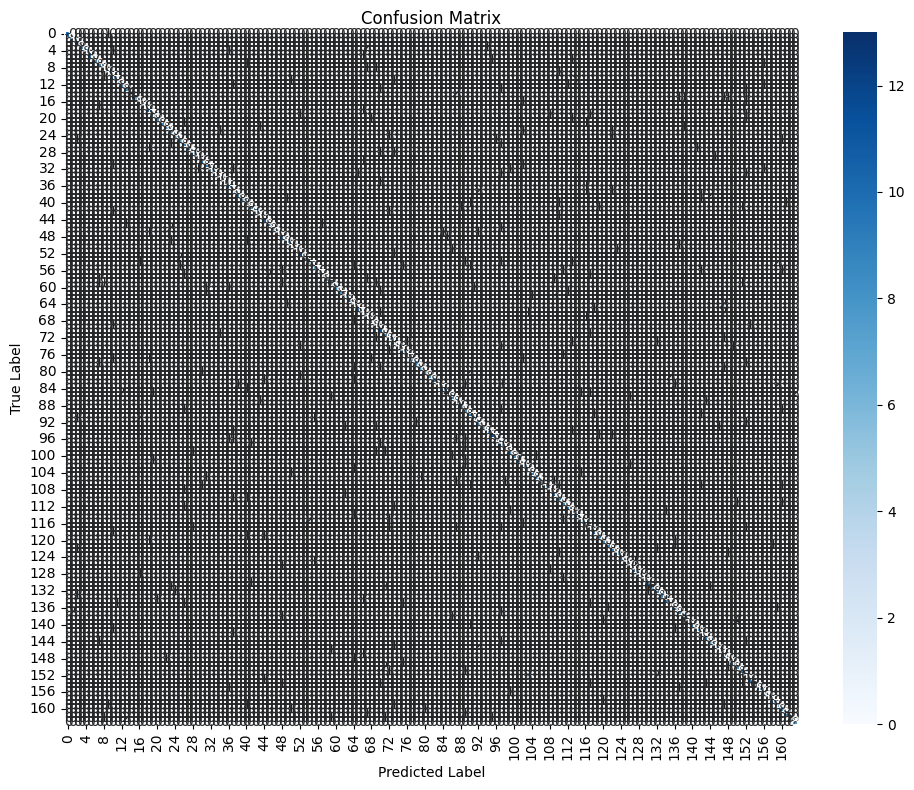

In [ ]:
import torch
from torch import nn
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, criterion, device='cuda'):
    """
    Evaluate the model on test data

    Args:
        model (nn.Module): The trained model
        test_loader (DataLoader): DataLoader containing test data
        criterion (nn.Module): Loss function
        device (str): Device to run evaluation on ('cuda' or 'cpu')

    Returns:
        dict: Dictionary containing evaluation metrics
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # Get batch data
            sequences = batch['sequence'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            person_ids = batch['person_id'].to(device)

            # Forward pass
            outputs = model(sequences, attention_mask)
            loss = criterion(outputs, person_ids)

            # Calculate predictions
            predictions = torch.argmax(outputs, dim=1)

            # Accumulate results
            total_loss += loss.item()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(person_ids.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(test_loader)
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Get detailed classification report
    report = classification_report(all_labels, all_predictions, output_dict=True)

    return {
        'test_loss': avg_loss,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_predictions,
        'true_labels': all_labels
    }

def plot_confusion_matrix(confusion_matrix, class_names=None):
    """
    Plot confusion matrix as a heatmap

    Args:
        confusion_matrix (np.ndarray): The confusion matrix to plot
        class_names (list, optional): List of class names
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if class_names:
        plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
        plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def print_evaluation_results(results):
    """
    Print evaluation metrics in a formatted way

    Args:
        results (dict): Dictionary containing evaluation results
    """
    print("\nEvaluation Results:")
    print(f"Test Loss: {results['test_loss']:.4f}")
    print(f"Accuracy: {results['accuracy']*100:.2f}%")

    print("\nDetailed Classification Report:")
    # Print per-class metrics
    for class_id in results['classification_report'].keys():
        if class_id not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics = results['classification_report'][class_id]
            print(f"\nClass {class_id}:")
            print(f"Precision: {metrics['precision']:.3f}")
            print(f"Recall: {metrics['recall']:.3f}")
            print(f"F1-Score: {metrics['f1-score']:.3f}")
            print(f"Support: {metrics['support']}")

    print("\nOverall Metrics:")
    macro_avg = results['classification_report']['macro avg']
    print(f"Macro Avg - Precision: {macro_avg['precision']:.3f}, "
          f"Recall: {macro_avg['recall']:.3f}, "
          f"F1-Score: {macro_avg['precision']:.3f}")

# Example usage:
# Initialize model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = YourModel().to(device)
criterion = nn.CrossEntropyLoss()

# Evaluate model
results = evaluate_model(model, test_loader, criterion, device)

# Print results
print_evaluation_results(results)

# Plot confusion matrix
plot_confusion_matrix(results['confusion_matrix'])

In [ ]:
# prompt: save the results['confusion_matrix'] in a csv file

import pandas as pd

# Assuming 'results' is already defined and contains the confusion matrix
# Replace 'confusion_matrix.csv' with your desired file name
pd.DataFrame(results['confusion_matrix']).to_csv('confusion_matrix_60.csv')

#To download the file:
from google.colab import files
files.download('confusion_matrix_60.csv')

In [ ]:
trainer.train(
    num_epochs=40,
    resume_path=None  # Set to checkpoint path to resume training
)


Epoch 1/40
train_cls_loss: 0.6274
train_accuracy: 0.8269
val_loss: 0.6156
val_accuracy: 0.8900


Epoch 2/40
train_cls_loss: 0.6415
train_accuracy: 0.8269
val_loss: 0.6590
val_accuracy: 0.8868


Epoch 3/40
train_cls_loss: 0.6215
train_accuracy: 0.8286
val_loss: 0.6403
val_accuracy: 0.8922


Epoch 4/40
train_cls_loss: 0.6074
train_accuracy: 0.8295
val_loss: 0.6525
val_accuracy: 0.8851


Epoch 5/40
train_cls_loss: 0.5949
train_accuracy: 0.8396
val_loss: 0.6486
val_accuracy: 0.8846


Epoch 6/40
train_cls_loss: 0.5710
train_accuracy: 0.8489
val_loss: 0.6401
val_accuracy: 0.8944


Epoch 7/40
train_cls_loss: 0.5643
train_accuracy: 0.8417
val_loss: 0.6158
val_accuracy: 0.8906


Epoch 8/40
train_cls_loss: 0.5886
train_accuracy: 0.8387
val_loss: 0.6240
val_accuracy: 0.8961


Epoch 9/40
train_cls_loss: 0.5423
train_accuracy: 0.8524
val_loss: 0.6356
val_accuracy: 0.8895


Epoch 10/40
train_cls_loss: 0.5659
train_accuracy: 0.8419
val_loss: 0.6709
val_accuracy: 0.8889


Epoch 11/40
train_cls_loss: 

In [ ]:
# torch.save(model.state_dict(),'skeleton_transformer_models/best_model_2.pt')
torch.save(model.state_dict(),'skeleton_transformer_models/best_aug_model_100.pt')
# from google.colab import files

# files.download('/content/skeleton_transformer_models/best_aug_model_100.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Evaluation Results:
Test Loss: 1.2300
Accuracy: 78.16%

Detailed Classification Report:

Class 0:
Precision: 0.733
Recall: 1.000
F1-Score: 0.846
Support: 11.0

Class 1:
Precision: 1.000
Recall: 0.750
F1-Score: 0.857
Support: 8.0

Class 2:
Precision: 0.867
Recall: 1.000
F1-Score: 0.929
Support: 13.0

Class 3:
Precision: 1.000
Recall: 0.909
F1-Score: 0.952
Support: 11.0

Class 4:
Precision: 1.000
Recall: 0.636
F1-Score: 0.778
Support: 11.0

Class 5:
Precision: 0.538
Recall: 0.636
F1-Score: 0.583
Support: 11.0

Class 6:
Precision: 0.455
Recall: 0.909
F1-Score: 0.606
Support: 11.0

Class 7:
Precision: 1.000
Recall: 0.545
F1-Score: 0.706
Support: 11.0

Class 8:
Precision: 1.000
Recall: 0.818
F1-Score: 0.900
Support: 11.0

Class 9:
Precision: 0.800
Recall: 0.364
F1-Score: 0.500
Support: 11.0

Class 10:
Precision: 1.000
Recall: 0.455
F1-Score: 0.625
Support: 11.0

Class 11:
Precision: 0.625
Recall: 0.909
F1-Score: 0.741
Support: 11.0

Class 12:
Precision: 1.000
Recall: 0.727
F1-Score: 0.842


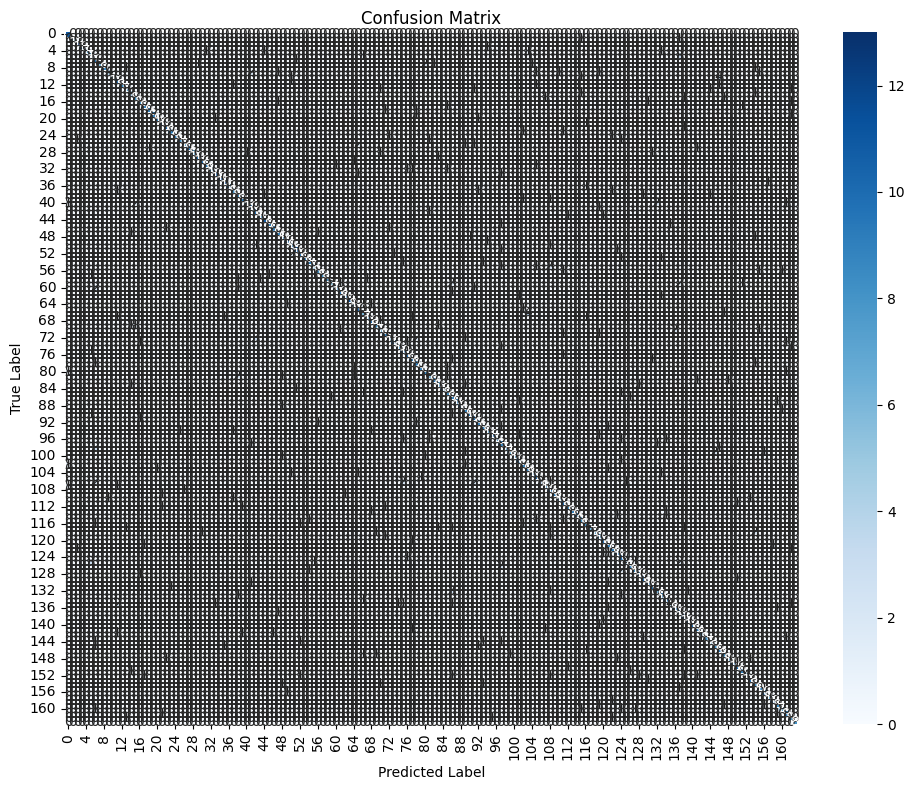

In [ ]:
import torch
from torch import nn
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, criterion, device='cuda'):
    """
    Evaluate the model on test data

    Args:
        model (nn.Module): The trained model
        test_loader (DataLoader): DataLoader containing test data
        criterion (nn.Module): Loss function
        device (str): Device to run evaluation on ('cuda' or 'cpu')

    Returns:
        dict: Dictionary containing evaluation metrics
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # Get batch data
            sequences = batch['sequence'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            person_ids = batch['person_id'].to(device)

            # Forward pass
            outputs = model(sequences, attention_mask)
            loss = criterion(outputs, person_ids)

            # Calculate predictions
            predictions = torch.argmax(outputs, dim=1)

            # Accumulate results
            total_loss += loss.item()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(person_ids.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(test_loader)
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Get detailed classification report
    report = classification_report(all_labels, all_predictions, output_dict=True)

    return {
        'test_loss': avg_loss,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_predictions,
        'true_labels': all_labels
    }

def plot_confusion_matrix(confusion_matrix, class_names=None):
    """
    Plot confusion matrix as a heatmap

    Args:
        confusion_matrix (np.ndarray): The confusion matrix to plot
        class_names (list, optional): List of class names
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if class_names:
        plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
        plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def print_evaluation_results(results):
    """
    Print evaluation metrics in a formatted way

    Args:
        results (dict): Dictionary containing evaluation results
    """
    print("\nEvaluation Results:")
    print(f"Test Loss: {results['test_loss']:.4f}")
    print(f"Accuracy: {results['accuracy']*100:.2f}%")

    print("\nDetailed Classification Report:")
    # Print per-class metrics
    for class_id in results['classification_report'].keys():
        if class_id not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics = results['classification_report'][class_id]
            print(f"\nClass {class_id}:")
            print(f"Precision: {metrics['precision']:.3f}")
            print(f"Recall: {metrics['recall']:.3f}")
            print(f"F1-Score: {metrics['f1-score']:.3f}")
            print(f"Support: {metrics['support']}")

    print("\nOverall Metrics:")
    macro_avg = results['classification_report']['macro avg']
    print(f"Macro Avg - Precision: {macro_avg['precision']:.3f}, "
          f"Recall: {macro_avg['recall']:.3f}, "
          f"F1-Score: {macro_avg['precision']:.3f}")

# Example usage:
# Initialize model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = YourModel().to(device)
criterion = nn.CrossEntropyLoss()

# Evaluate model
results = evaluate_model(model, test_loader, criterion, device)

# Print results
print_evaluation_results(results)

# Plot confusion matrix
plot_confusion_matrix(results['confusion_matrix'])

In [ ]:
# # prompt: save the results['confusion_matrix'] in a csv file

import pandas as pd

# Assuming 'results' is already defined and contains the confusion matrix
# Replace 'confusion_matrix.csv' with your desired file name
pd.DataFrame(results['confusion_matrix']).to_csv('confusion_matrix_100.csv')

#To download the file:
from google.colab import files
files.download('confusion_matrix_100.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r augmented_data.zip /content/content/processed_skeleton_data

updating: content/content/processed_skeleton_data/ (stored 0%)
  adding: content/content/processed_skeleton_data/Person043_12.csv (deflated 53%)
  adding: content/content/processed_skeleton_data/Person078_11.csv (deflated 54%)
  adding: content/content/processed_skeleton_data/Person039_33.csv (deflated 55%)
  adding: content/content/processed_skeleton_data/Person140_33.csv (deflated 55%)
  adding: content/content/processed_skeleton_data/Person160_34.csv (deflated 54%)
  adding: content/content/processed_skeleton_data/Person013_44.csv (deflated 54%)
  adding: content/content/processed_skeleton_data/Person111_1.csv (deflated 56%)
  adding: content/content/processed_skeleton_data/Person068_30.csv (deflated 57%)
  adding: content/content/processed_skeleton_data/Person048_13.csv (deflated 55%)
  adding: content/content/processed_skeleton_data/Person106_20.csv (deflated 56%)
  adding: content/content/processed_skeleton_data/Person153_34.csv (deflated 54%)
  adding: content/content/processed_